# Training eines neuronalen Netzes

In diesem Skript wird das Training eines neuronalen Netzes durchgeführt. Dazu werden die folgende Schritte der Reihe nach durchgeführt:

0. Vorbereitung (Laden der Bibliotheken und Einstellungen
1. Laden der Bilder
2. Erzeugen Trainingsdaten & Testdaten
3. Definition und Aufbau des Netzes
4. Training
5. Speichern des neuronalen Netzes

### 0) Vorbereitung

##### Modelname
Damit verschiedene Versionen des neuronalen Netzes unterschieden werden, wird gleich zu Beginn ein eindeutiger Name für das Model definiert. Dieser Name wird sollte jeweils zu Beginn jedes Skripts identisch sein, damit konsistent mit denselben Daten gearbeitet wird.

##### Bibliotheken
Anschließend müssen unterschiedliche Bibliotheken für die Datei- und Bildverarbeitung, sowie für die Definition und den Aufbau von neuronalen Netzen mittels der Bibliothek Tensorflow geladen werden

In [1]:
###############################################################################

ModelNameAndVersion = "dig-01"

###############################################################################


import matplotlib.pyplot as plt
import glob
import os
from PIL import Image 
import numpy as np
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


### 1) Laden der Trainingsbilder
Die Trainingsbilder werden aus einem Verzeichnis geladen. Da neben dem Bild auch die Klassifizierung notwendig ist, wird diese direkt im Dateinamen nach folgender Nomenklatur gespeichert:

Die Bilddaten und die Klassifizierung wird in den beiden Arrays x_data (Bilddaten) und y_data (Klassifizierung) gespeichert:

In [2]:
###### Festlegen der Variablen und Initialisieren der Arrays ########################
Input_dir='bilder_resize'
x_data = []
y_data = []


###### Laden der Bildateien in einer Schleife über als jpeg-Bilder ##################
files = glob.glob(Input_dir + '/*.jpg')
for aktfile in files:
    img = Image.open(aktfile)                              # Laden der Bilddaten
    data = np.array(img)
    x_data.append(data)
    
    Dateiname      = os.path.basename(aktfile)             # Dateiname
    Classification = Dateiname[0:1]                        # 1. Ziffer = Zielwert
    if Classification == "N":
        category = 10                          
    else:
        category = int(Classification)
    category_vektor = tf.keras.utils.to_categorical(category, 11) # Umwandlung in Vektor
    y_data.append(category_vektor)

x_data = np.array(x_data)
y_data = np.array(y_data)

print(x_data.shape)
print(y_data.shape)


(490, 32, 20, 3)
(490, 11)


### 2) Erzeugen Trainingsdaten & Testdaten

##### Mischen und Zerteilung der Trainingsdaten
Zunächst werden die geladenen Bilder über die Funktion "shuffle" gemischt. Durch die Verwendung von x_data und y_data gleichzeit, wird die Zuordnung im Array erhalten

Anschließend werden die Bilddaten in Trainingsdaten (x/y_train) und Testdaten (x/y_test) aufgeteilt.

##### Image Augmentation
Als nächste wird der im ersten Teil schon bekannte ImageDataGenerator definiert, der die Eingangsbilder mit den verschiedenen Parametern (shift, brightness, zoom, rotation) zufällig modifiziert und dann ausgibt.
Hier wird nun eine Batchgröße von 4 verwendet, diese hat sich in verschiedenen Netzgeometrien bewährt.
Der Generator wird sowohl auf die Trainings- wie auch auf die Testdaten angewendet.

In [3]:
x_data, y_data = shuffle(x_data, y_data)

Training_Percentage = 0.2
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=Training_Percentage)
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)


### Image Augmentation
Shift_Range = 2
Brightness_Range = 0.3
Rotation_Angle = 5
ZoomRange = 0.2

### OHNE Image Augmentation
#Shift_Range = 0
#Brightness_Range = 0
#Rotation_Angle = 0
#ZoomRange = 0

datagen = ImageDataGenerator(width_shift_range  = [-Shift_Range, Shift_Range], 
                             height_shift_range = [-Shift_Range, Shift_Range],
                             brightness_range   = [1-Brightness_Range, 1+Brightness_Range],
                             zoom_range         = [1-ZoomRange, 1+ZoomRange],
                             rotation_range     = Rotation_Angle)
Batch_Size = 4
train_iterator      = datagen.flow(x_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(x_test,  y_test,  batch_size=Batch_Size)

(392, 32, 20, 3)
(98, 32, 20, 3)
(392, 11)
(98, 11)


### 3) Definition und Aufbau des Netzes
Das Layout besteht aus einer Abfolge von **Convolutional** und **MaxPooling** Layern. Zu Beginn kommt noch ein Layer zum Normalisieren der Eingangsdaten. Vor dem Ausgangslayer gibt es noch einen "flachen" Layer mit 512 Neuronen.

##### Input
* Bilder der Größe 32x20 Pixel mit 3 Farbkanalen --> input_shape = (32,20,3)

##### Output
* 11 Neuronen: Ziffern 0, 1, ..., 9 + Not-A-Number als Sonderfall

#### Kompilieren
Zum Abschluss wird hier das Netzwerk noch Kompiliert, damit es für die Verwendung verwendbar ist. Die Detailparameter hierfür findet man in der einschlägigen Literatur

In [4]:
model = tf.keras.Sequential()

model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(16, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(16, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))

model.summary()

model.compile(loss= tf.keras.losses.categorical_crossentropy, 
              optimizer= tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), 
              metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 16)          0

### 4) Training des Netzes
Beim Training müssen die Anzahl der Trainingszyklen (Epoch_Anz) und die Größe der gleichzeitig trainierten Bilder (Batch_Size) definiert werden

In [5]:
Epoch_Anz  = 100
history = model.fit(train_iterator, 
                    validation_data = validation_iterator, 
                    epochs          = Epoch_Anz)


Epoch 1/100
98/98 [==============================] - 2s 12ms/step - loss: 2.1611 - accuracy: 0.3715 - val_loss: 2.2763 - val_accuracy: 0.3469
Epoch 2/100
98/98 [==============================] - 0s 5ms/step - loss: 1.7425 - accuracy: 0.4640 - val_loss: 1.9622 - val_accuracy: 0.3776
Epoch 3/100
98/98 [==============================] - 0s 4ms/step - loss: 1.5952 - accuracy: 0.5297 - val_loss: 1.5454 - val_accuracy: 0.5408
Epoch 4/100
98/98 [==============================] - 0s 4ms/step - loss: 1.4667 - accuracy: 0.5556 - val_loss: 1.4736 - val_accuracy: 0.5918
Epoch 5/100
98/98 [==============================] - 0s 4ms/step - loss: 1.2110 - accuracy: 0.6392 - val_loss: 1.5515 - val_accuracy: 0.5000
Epoch 6/100
98/98 [==============================] - 0s 4ms/step - loss: 1.0078 - accuracy: 0.6903 - val_loss: 1.3679 - val_accuracy: 0.5918
Epoch 7/100
98/98 [==============================] - 0s 4ms/step - loss: 0.9746 - accuracy: 0.6908 - val_loss: 1.5249 - val_accuracy: 0.4694
Epoch 8/100


Epoch 59/100
98/98 [==============================] - 0s 5ms/step - loss: 0.0850 - accuracy: 0.9700 - val_loss: 0.6824 - val_accuracy: 0.8367
Epoch 60/100
98/98 [==============================] - 0s 4ms/step - loss: 0.1504 - accuracy: 0.9595 - val_loss: 0.5504 - val_accuracy: 0.8673
Epoch 61/100
98/98 [==============================] - 0s 5ms/step - loss: 0.0679 - accuracy: 0.9837 - val_loss: 0.6370 - val_accuracy: 0.8469
Epoch 62/100
98/98 [==============================] - 0s 5ms/step - loss: 0.0690 - accuracy: 0.9873 - val_loss: 0.4215 - val_accuracy: 0.8673
Epoch 63/100
98/98 [==============================] - 0s 5ms/step - loss: 0.0905 - accuracy: 0.9707 - val_loss: 0.4553 - val_accuracy: 0.8673
Epoch 64/100
98/98 [==============================] - 0s 4ms/step - loss: 0.0530 - accuracy: 0.9798 - val_loss: 0.7356 - val_accuracy: 0.8571
Epoch 65/100
98/98 [==============================] - 0s 5ms/step - loss: 0.0712 - accuracy: 0.9759 - val_loss: 0.6746 - val_accuracy: 0.8776
Epoch 

### Visualisierung der Trainingsergebnisse

Nun kann man den Verlauf des Trainings visualisieren
Dabei wird sowohl der Fehler in den Trainingsdaten, wie auch in den Testdaten aufgetragen.

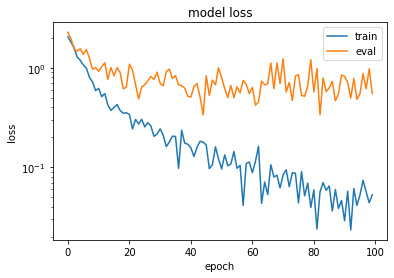

In [6]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper right')
plt.show()

### 5) Speichern des neuronalen Netzes

Zum Abschluss wird das neuronale Netz noch für die weitere Verwendung gespeichert. Hier wird zunächst das vollständige Netz im sogenannten H5-Format gespeichert. Ein Umwandlung in das für die Programmierung im dritten Teil notwendige tflite-Format erfolgt in einem anderen Skript.

In [7]:
## H5-Format
model.save('saved_model/' + ModelNameAndVersion)

INFO:tensorflow:Assets written to: saved_model/dig-01\assets
